In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import transforms
import random

precision = 4
torch.set_printoptions(precision,sci_mode=False)
np.set_printoptions(precision)

device = torch.device("cuda:0")
dtype_numpy = np.float64
dtype_torch = torch.float64

In [0]:
# importing data from drive
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/My\ Drive/Colab\ Notebooks/Data/DeepLearning_fa19_hw6_prob1.zip;

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/Colab Notebooks/Data/DeepLearning_fa19_hw6_prob1.zip
replace DeepLearning_fa19_HW6_Prob1/train.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### HW6 Question 1 Part a


-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------

In [0]:
# code to visualize one hot encoded numpy array (for debugging)
def plot_onehot(x):
  """
  takes array x with dimensions (# classes, image height, image width)
  and plots it with plt.imshow()
  """
  indices = np.argmax(x,0)
  plt.imshow(indices, cmap='Pastel1',vmin=0,vmax=7)

In [0]:
# Dataset Creation Class
# in general, mask = target
class ImageDataset(Dataset):
    def __init__(self,input_dir,mode = 'none',transform=False):
      self.mode = mode
      self.transform_bool = transform
      if self.mode == 'dice':
        self.image_pathlist = glob.glob(input_dir + '/*/*_input.jpg')
        self.mask_pathlist = glob.glob(input_dir + '/*/*_mask.png')
      else:
        self.image_pathlist = glob.glob(input_dir + '/*/*_gray.jpg')
        self.mask_pathlist = glob.glob(input_dir + '/*/*_input.jpg')

    def __len__ (self):
      return len(self.image_pathlist)

    def transform(self,im,mask):
      if random.random() > 0.5:
        im = transforms.functional.hflip(im)
        mask = transforms.functional.hflip(mask)
      if random.random() > 0.5:  
        im = transforms.functional.vflip(im)
        mask = transforms.functional.vflip(mask)        
      return im, mask

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      # opens image files with shape (channels, image height, image width)
      im = Image.open(self.image_pathlist[idx])
      # opens mask files with shape (channels, image height, image width)
      mask = Image.open(self.mask_pathlist[idx])

      if self.transform_bool:
        im, mask = self.transform(im, mask)

      im = ToTensor()(im)
      mask = ToTensor()(mask)

      # initializes one hot encoded array for dice loss
      # shape (num_classes, image height, image width)
      if self.mode =='dice':
        # rounds the mask pixel values to whole numbers, 255/32 derived from mapping file
        mask = torch.round(mask*255/32)
        target = torch.zeros([8,mask.size()[1],mask.size()[2]],dtype=float)
        # assigns a class label for each unique pixel value in mask
        for i in range(num_classes):
          # create True and False boolean array 'indices' of size (image height, image width)
          # squeeze mask because its in shape (1, image height, image width)
          indices = (mask.squeeze() == i)
          target[i,indices] = 1
      # just have labels be the given label input 
      # mode 'color' should use this
      else:
        target = mask

      item = {'image': im, 'mask': target}
      return item

In [0]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    # Use batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    # No batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

In [0]:
# Upsampling

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

In [0]:
# unet cell
# U-Net
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1 = add_conv_stage(3, 32, useBN=useBN)
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    # final layer
    self.conv5 = nn.Conv2d(32,8,kernel_size=1,stride=1,padding=0,bias=True)
    # weight initialization
    # You can have your own weight intialization. This is just an example.
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        m.reset_parameters()
        #torch.nn.init.xavier_normal_(m.weight.data) # bad
        #torch.nn.init.xavier_uniform_(m.weight.data) # bad
        torch.nn.init.kaiming_normal_(m.weight.data) # not as bad, can be spotty
        #torch.nn.init.normal_(m.weight.data) # bad
        #torch.nn.init.kaiming_uniform_(m.weight.data) # bad, very spotty
        if m.bias is not None:
          m.bias.data.zero_()

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out  = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out  = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out  = self.conv1m(conv2m_out_)
    # final 1 x 1 convolutional layer with softmax activation
    convfinal_out = functional.softmax(self.conv5(conv1m_out), dim=1)
    # convfinal_out = functional.leaky_relu(self.conv5(conv1m_out), negative_slope=0.1)
    #convfinal_out = torch.sigmoid(self.conv5(conv1m_out))

    return convfinal_out

In [0]:
# diceloss cell
class DICELoss(nn.Module):
  def __init__(self):
    super(DICELoss, self).__init__()
    # smoothing
    self.smooth = 1
  
  def forward(self, output_array, target_array):
    # extracts batch_size from first dimension of target array
    batch_size = target_array.size()[0]

    # flattens output array and target array so that there is one
    # flattened vector for each example in the batch and each class
    output_flat = output_array.view(batch_size,num_classes,-1)
    target_flat = target_array.view(batch_size,num_classes,-1)

    # calculates intersection between output and target. It will be higher if 
    # probability in output vector is larger for the nonzero value in target one
    # hot encoded vector
    intersection = torch.sum(output_flat * target_flat, dim=(0,2))

    
    # loss is caculated as 1 - dice score
    # per class and example, the dice score is 2 * intersection = smoothing constant / (sum of individual
    # sets + smoothing constant)
    # smoothing is implemented for cases where certain classes do not show up in the image
    # the dice_score below is an array of size (batch_size, num_classes)
    numerator = 2. * intersection + self.smooth
    denominator = torch.sum(output_flat,dim=(0,2)) + torch.sum(target_flat,dim=(0,2)) + self.smooth
    dice_score = numerator / denominator
    # print(dice_score)

    # we then take the mean over all classes
    dice_score = torch.mean(dice_score)

    loss = 1 - dice_score
    return loss

In [0]:
def experiment_main_1a(iteration,num_example,seed_index,num_epoch,learning_rate):
  # experiment cell
  # problem 1a
  # hyperparameters
  learning_rate = learning_rate
  num_epoch =  num_epoch

  torch.manual_seed(seed_index+iteration)
  num_steps_per_val = 20

  model = unet(useBN=True)

  model.cuda()
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  info = []

  # ImageDataset Objects
  image_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/train', mode='dice')
  val_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/validation',mode = 'dice')

  # dataloader objects and enumerate for train and test datasets
  dataloader_train = DataLoader(image_dataset, batch_size = train_batch_size, shuffle=True)
  # dataloader_train_iterator = enumerate(dataloader_train)

  dataloader_validation = DataLoader(val_dataset, batch_size = validation_batch_size, shuffle=True)
  # dataloader_validation_iterator = enumerate(dataloader_validation)

  best_val_err = 1.0
  fig, ax = plt.subplots(3, 1, sharex=True)

  print("Start Training...Seed", seed_index+ iteration,'...lr: ',learning_rate)
  convergence_counter = 0
  for epoch in range(num_epoch):
    ########################### Training #####################################
    dataloader_train_iterator = enumerate(dataloader_train)
    i_batch,item_batch = next(dataloader_train_iterator)
    input_batch = item_batch['image'].cuda()
    label_batch = item_batch['mask'].cuda()
    output_batch = model(input_batch)

    # unit tested label_batch is the one hot encoded array mask/label
    # plot_onehot(label_batch[0].cpu().detach().numpy())

    # Compute loss (and error rate).
    loss_fn = DICELoss()
    loss = loss_fn(output_batch, label_batch)  
    train_loss = loss.item()

        
    # resets gradients and does backpropagation to find gradients
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    scheduler.step()

    # converts tensors to numpy arrays for computation to reduce CUDA memory usage
    output_batch = output_batch.cpu().detach().numpy()
    label_batch = label_batch.float().cpu().detach().numpy()

    # output_batch is shape (batch_size, #classes, image size tuple) 
    # every value is the probability of the class for that example for a certain pixel
    output_batch_indices = np.argmax(output_batch,axis = 1)
    # output_batch_indices is of shape (batch_size,image size tuple)
    # label_batch is a one hot encoded tensor of shape (batch_size,#classes, image size tuple)
    # a correct match would then be output_batch_indices == max(label_batch in the class dimen)

    train_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()
    


    ########################### Validation #####################################
    if epoch % num_steps_per_val == 0:
      with torch.no_grad():
        # print("\nEPOCH " +str(epoch+1)+" of "+str(num_epoch)+"\n")
        model.eval()

        dataloader_validation_iterator = enumerate(dataloader_validation)
        i_batch,item_batch = next(dataloader_validation_iterator)
        input_batch = item_batch['image'].cuda()
        label_batch = item_batch['mask'].cuda()
        output_batch = model(input_batch)
        
        # computes loss using dice loss
        loss_fn = DICELoss()
        loss = loss_fn(output_batch, label_batch)  
        val_loss = loss.item()

        # converts tensors to numpy arrays for computation to reduce CUDA memory usage
        output_batch = output_batch.cpu().detach().numpy()
        output_batch_indices = np.argmax(output_batch,axis = 1)
        label_batch = label_batch.float().cpu().detach().numpy()
        
        # computes error rate by comparing predicted class and true class for all batch examples
        val_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()

        if val_err < best_val_err:
              best_val_err = val_err
              print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(epoch, best_val_err))
              convergence_counter = 0
        else:
              convergence_counter +=1
              # if convergence_counter > number of validation checks
              if convergence_counter > 50:
                print('stopped training on epoch: ', epoch)
                break

        # plotting
        info.append([epoch, train_loss, val_loss, train_err, val_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'Val loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'Val err'])
        ax[2].plot(x[1:],y21[1:],x[1:],y22[1:])
        ax[2].legend(['Train err skip first iteration','Val err skip first iteration'])
  plt.show()

  # test performance

  with torch.no_grad():
    test_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test', mode='dice')
    dataloader_test = DataLoader(test_dataset, batch_size = 49, shuffle=False) # 49 because of 49 test images

    dataloader_test_iterator = enumerate(dataloader_test)
    _,batch_data = next(dataloader_test_iterator)

    input_batch = batch_data['image'].cuda()
    label_batch = batch_data['mask'].cuda()

    output_batch = model(input_batch)

    output_batch = output_batch.cpu().detach().numpy()
    output_batch_indices = np.argmax(output_batch,axis = 1)

    fig = plt.figure()
    fig.set_figheight(5*2)
    fig.set_figwidth(5*num_example)
    offset = 7
    for i in range(num_example):
      plt.subplot(2,num_example,i+1)
      plot_onehot(output_batch[i,:,:,:])
      plt.subplot(2,num_example,i+num_example+1)
      plot_onehot(label_batch[i,:,:,:].cpu().detach().numpy())
      # older code to check if raw images are right
      # plt.subplot(3,num_examples,i+2*num_examples+1)
      # plt.imshow(input_batch[i].cpu().detach().numpy().transpose((1,2,0)))
    plt.show()


    # computes error rate by comparing predicted class and true class for all batch examples
    test_err = 1.0 - (output_batch_indices == np.argmax(label_batch.float().cpu().detach().numpy(),axis=1)).mean()

    print("test accuracy: %0.4f" %(1-test_err))

Start Training...Seed 3800 ...lr:  0.001
Step     0: Obtained a best validation error of 0.960.
Step    20: Obtained a best validation error of 0.192.


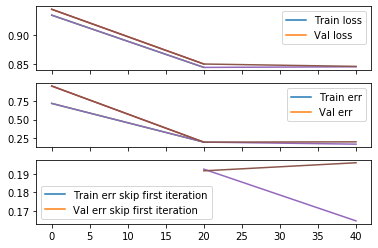

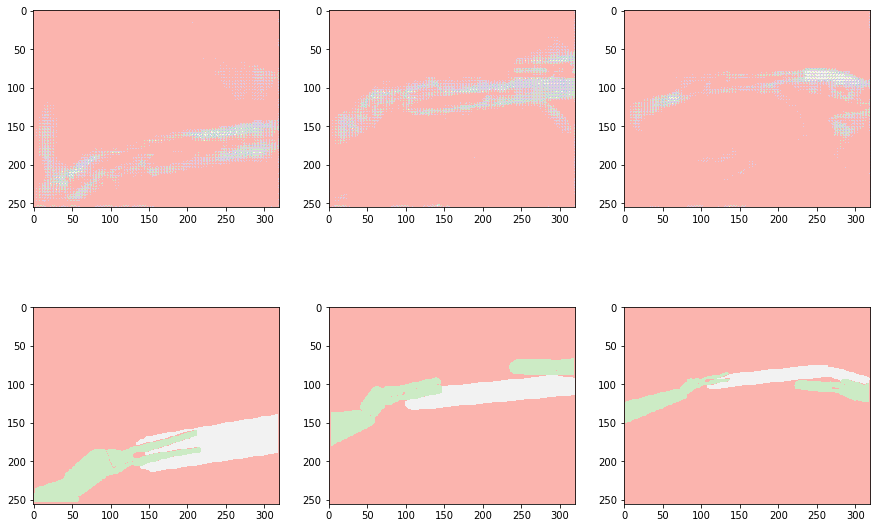

test accuracy: 0.8227


In [0]:
# variables
# lr .001, seed 3800, train_batch_size 10, at least 41 epochs to get report results
num_classes = 8
train_batch_size = 10
validation_batch_size= 50
seed_index = 3800
num_seed =  1
num_example = 3
# max epochs
num_epoch = 41
learning_rate_list = [.001]
for i in range(num_seed):
  for k in range(len(learning_rate_list)):
    experiment_main_1a(iteration=i,num_example=num_example,seed_index=seed_index,num_epoch=num_epoch,learning_rate = learning_rate_list[k])

### HW6 Question 1 part b

-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------




In [0]:
def experiment_main_1b(iteration,num_example,seed_index,num_epoch,learning_rate):
  # experiment cell
  # problem 1a
  # hyperparameters
  learning_rate = learning_rate
  num_epoch =  num_epoch

  torch.manual_seed(seed_index+iteration)
  num_steps_per_val = 20

  model = unet(useBN=True)

  model.cuda()
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  info = []

  # ImageDataset Objects
  image_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/train', mode='dice',transform=True)
  val_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/validation',mode = 'dice',transform=True)

  # dataloader objects and enumerate for train and test datasets
  dataloader_train = DataLoader(image_dataset, batch_size = train_batch_size, shuffle=True)
  # dataloader_train_iterator = enumerate(dataloader_train)

  dataloader_validation = DataLoader(val_dataset, batch_size = validation_batch_size, shuffle=True)
  # dataloader_validation_iterator = enumerate(dataloader_validation)

  best_val_err = 1.0
  fig, ax = plt.subplots(3, 1, sharex=True)

  print("Start Training...Seed", seed_index+ iteration,'...lr: ',learning_rate)
  convergence_counter = 0
  for epoch in range(num_epoch):
    ########################### Training #####################################
    dataloader_train_iterator = enumerate(dataloader_train)
    i_batch,item_batch = next(dataloader_train_iterator)
    input_batch = item_batch['image'].cuda()
    label_batch = item_batch['mask'].cuda()
    output_batch = model(input_batch)

    # unit tested label_batch is the one hot encoded array mask/label
    # plot_onehot(label_batch[0].cpu().detach().numpy())

    # Compute loss (and error rate).
    loss_fn = DICELoss()
    loss = loss_fn(output_batch, label_batch)  
    train_loss = loss.item()

    # resets gradients and does backpropagation to find gradients
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    scheduler.step()

    # converts tensors to numpy arrays for computation to reduce CUDA memory usage
    output_batch = output_batch.cpu().detach().numpy()
    label_batch = label_batch.float().cpu().detach().numpy()

    # output_batch is shape (batch_size, #classes, image size tuple) 
    # every value is the probability of the class for that example for a certain pixel
    output_batch_indices = np.argmax(output_batch,axis = 1)
    # output_batch_indices is of shape (batch_size,image size tuple)
    # label_batch is a one hot encoded tensor of shape (batch_size,#classes, image size tuple)
    # a correct match would then be output_batch_indices == max(label_batch in the class dimen)

    train_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()
    
    ########################### Validation #####################################
    if epoch % num_steps_per_val == 0:
      with torch.no_grad():
        # print("\nEPOCH " +str(epoch+1)+" of "+str(num_epoch)+"\n")
        model.eval()

        dataloader_validation_iterator = enumerate(dataloader_validation)
        i_batch,item_batch = next(dataloader_validation_iterator)
        input_batch = item_batch['image'].cuda()
        label_batch = item_batch['mask'].cuda()
        output_batch = model(input_batch)
        
        # computes loss using dice loss
        loss_fn = DICELoss()
        loss = loss_fn(output_batch, label_batch)  
        val_loss = loss.item()

        # converts tensors to numpy arrays for computation to reduce CUDA memory usage
        output_batch = output_batch.cpu().detach().numpy()
        output_batch_indices = np.argmax(output_batch,axis = 1)
        label_batch = label_batch.float().cpu().detach().numpy()
        
        # computes error rate by comparing predicted class and true class for all batch examples
        val_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()

        if val_err < best_val_err:
              best_val_err = val_err
              print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(epoch, best_val_err))
              convergence_counter = 0
        else:
              convergence_counter +=1
              # if convergence_counter > number of validation checks
              if convergence_counter > 50:
                print('stopped training on epoch: ', epoch)
                break

        # plotting
        info.append([epoch, train_loss, val_loss, train_err, val_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'Val loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'Val err'])
        ax[2].plot(x[1:],y21[1:],x[1:],y22[1:])
        ax[2].legend(['Train err skip first iteration','Val err skip first iteration'])
  plt.show()

  # test performance

  with torch.no_grad():
    test_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test', mode='dice')
    dataloader_test = DataLoader(test_dataset, batch_size = 49, shuffle=False) # 49 because of 49 test images

    dataloader_test_iterator = enumerate(dataloader_test)
    _,batch_data = next(dataloader_test_iterator)

    input_batch = batch_data['image'].cuda()
    label_batch = batch_data['mask'].cuda()

    output_batch = model(input_batch)

    output_batch = output_batch.cpu().detach().numpy()
    output_batch_indices = np.argmax(output_batch,axis = 1)

    fig = plt.figure()
    fig.set_figheight(5*2)
    fig.set_figwidth(5*num_example)
    offset = 7
    for i in range(num_example):
      plt.subplot(2,num_example,i+1)
      plot_onehot(output_batch[i,:,:,:])
      plt.subplot(2,num_example,i+num_example+1)
      plot_onehot(label_batch[i,:,:,:].cpu().detach().numpy())
      # older code to check if raw images are right
      # plt.subplot(3,num_examples,i+2*num_examples+1)
      # plt.imshow(input_batch[i].cpu().detach().numpy().transpose((1,2,0)))
    plt.show()

    # computes error rate by comparing predicted class and true class for all batch examples
    test_err = 1.0 - (output_batch_indices == np.argmax(label_batch.float().cpu().detach().numpy(),axis=1)).mean()

    print("test accuracy: %0.4f" %(1-test_err))

Start Training...Seed 3800 ...lr:  0.001
Step     0: Obtained a best validation error of 0.968.
Step    20: Obtained a best validation error of 0.196.
Step    40: Obtained a best validation error of 0.194.


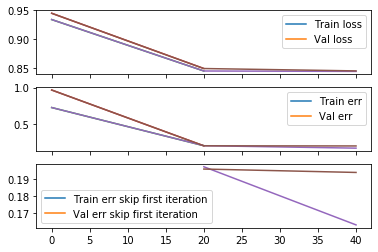

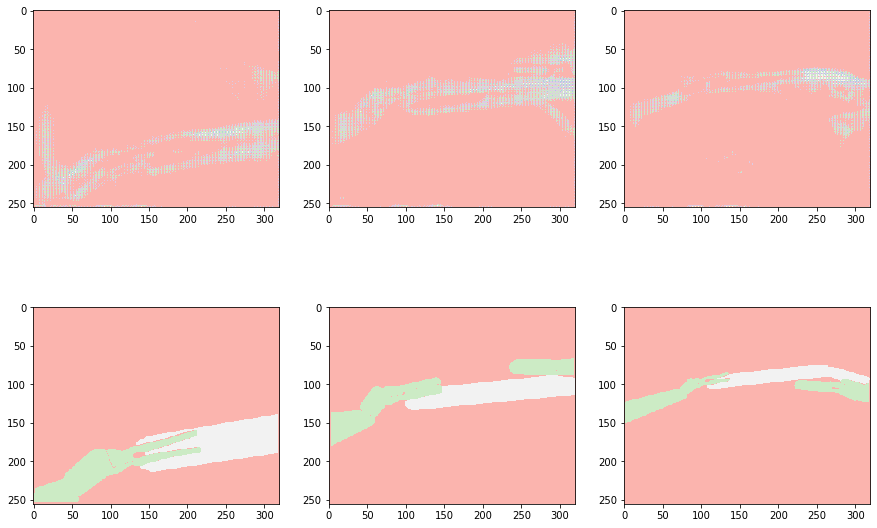

test accuracy: 0.8244


In [0]:
# variables
num_classes = 8
train_batch_size = 10
validation_batch_size= 50
seed_index = 3800
num_seed =  1
num_example = 3
# max epochs
num_epoch = 41
learning_rate_list = [.001]

for i in range(num_seed):
  for k in range(len(learning_rate_list)):
    experiment_main_1b(iteration=i,num_example=num_example,seed_index=seed_index,num_epoch=num_epoch,learning_rate = learning_rate_list[k])

### HW6 Problem 1 Part c
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------


In [0]:
def experiment_main_1c(iteration,num_example,seed_index,num_epoch,learning_rate):
  # experiment cell
  # problem 1a
  # hyperparameters
  learning_rate = learning_rate
  num_epoch =  num_epoch

  torch.manual_seed(seed_index+iteration)
  num_steps_per_val = 20

  model = unet(useBN=True)

  model.cuda()
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

  info = []

  # ImageDataset Objects
  image_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/train', mode='dice',transform=True)
  val_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/validation',mode = 'dice',transform=True)

  # dataloader objects and enumerate for train and test datasets
  dataloader_train = DataLoader(image_dataset, batch_size = train_batch_size, shuffle=True)
  # dataloader_train_iterator = enumerate(dataloader_train)

  dataloader_validation = DataLoader(val_dataset, batch_size = validation_batch_size, shuffle=True)
  # dataloader_validation_iterator = enumerate(dataloader_validation)

  best_val_err = 1.0
  fig, ax = plt.subplots(2, 1, sharex=True)

  print("Start Training...Seed", seed_index+ iteration,'...lr: ',learning_rate)
  convergence_counter = 0
  for epoch in range(num_epoch):
    ########################### Training #####################################
    model.train()

    dataloader_train_iterator = enumerate(dataloader_train)
    i_batch,item_batch = next(dataloader_train_iterator)
    input_batch = item_batch['image'].cuda()
    label_batch = item_batch['mask'].cuda()

    output_batch = model(input_batch)

    # unit tested label_batch is the one hot encoded array mask/label
    # plot_onehot(label_batch[0].cpu().detach().numpy())

    # Compute loss (and error rate).
    loss_fn = DICELoss()
    loss = loss_fn(output_batch, label_batch)  
    train_loss = loss.item()

    # resets gradients and does backpropagation to find gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # converts tensors to numpy arrays for computation to reduce CUDA memory usage
    output_batch = output_batch.cpu().detach().numpy()
    label_batch = label_batch.float().cpu().detach().numpy()

    # output_batch is shape (batch_size, #classes, image size tuple) 
    # every value is the probability of the class for that example for a certain pixel
    output_batch_indices = np.argmax(output_batch,axis = 1)
    # output_batch_indices is of shape (batch_size,image size tuple)
    # label_batch is a one hot encoded tensor of shape (batch_size,#classes, image size tuple)
    # a correct match would then be output_batch_indices == max(label_batch in the class dimen)

    train_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()
    

    ########################### Validation #####################################
    if epoch % num_steps_per_val == 0:
      with torch.no_grad():
        # print("\nEPOCH " +str(epoch+1)+" of "+str(num_epoch)+"\n")
        model.eval()

        dataloader_validation_iterator = enumerate(dataloader_validation)
        i_batch,item_batch = next(dataloader_validation_iterator)
        input_batch = item_batch['image'].cuda()
        label_batch = item_batch['mask'].cuda()
        output_batch = model(input_batch)
        
        # computes loss using dice loss
        loss_fn = DICELoss()
        loss = loss_fn(output_batch, label_batch)  
        val_loss = loss.item()

        # converts tensors to numpy arrays for computation to reduce CUDA memory usage
        output_batch = output_batch.cpu().detach().numpy()
        output_batch_indices = np.argmax(output_batch,axis = 1)
        label_batch = label_batch.float().cpu().detach().numpy()
        
        # computes error rate by comparing predicted class and true class for all batch examples
        val_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()

        if val_err < best_val_err:
              best_val_err = val_err
              print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(epoch, best_val_err))
              convergence_counter = 0
        else:
              convergence_counter +=1
              # if convergence_counter > number of validation checks
              if convergence_counter > 50:
                print('stopped training on epoch: ', epoch)
                break

        # plotting
        info.append([epoch, train_loss, val_loss, train_err, val_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'Val loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'Val err'])
        # ax[2].plot(x[1:],y21[1:],x[1:],y22[1:])
        # ax[2].legend(['Train err skip first iteration','Val err skip first iteration'])
  plt.show()

  # test performance

  with torch.no_grad():
    test_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test', mode='dice')
    dataloader_test = DataLoader(test_dataset, batch_size = 49, shuffle=False) # 49 because of 49 test images

    dataloader_test_iterator = enumerate(dataloader_test)
    _,batch_data = next(dataloader_test_iterator)

    input_batch = batch_data['image'].cuda()
    label_batch = batch_data['mask'].cuda()

    output_batch = model(input_batch)

    output_batch = output_batch.cpu().detach().numpy()
    output_batch_indices = np.argmax(output_batch,axis = 1)

    fig = plt.figure()
    fig.set_figheight(5*2)
    fig.set_figwidth(5*num_example)
    offset = 7
    for i in range(num_example):
      plt.subplot(3,num_example,i+1)
      plot_onehot(output_batch[i,:,:,:])
      plt.subplot(3,num_example,i+num_example+1)
      plot_onehot(label_batch[i,:,:,:].cpu().detach().numpy())
      # code to check if raw images are right
      plt.subplot(3,num_example,i+2*num_example+1)
      plt.imshow(input_batch[i].cpu().detach().numpy().transpose((1,2,0)))
    plt.show()


    # computes error rate by comparing predicted class and true class for all batch examples
    test_err = 1.0 - (output_batch_indices == np.argmax(label_batch.float().cpu().detach().numpy(),axis=1)).mean()

    print("test accuracy: %0.4f" %(1-test_err))

Start Training...Seed 1737 ...lr:  0.001
Step     0: Obtained a best validation error of 0.871.
Step    20: Obtained a best validation error of 0.309.
Step    40: Obtained a best validation error of 0.197.
Step    60: Obtained a best validation error of 0.165.
Step    80: Obtained a best validation error of 0.134.
Step   100: Obtained a best validation error of 0.109.
Step   120: Obtained a best validation error of 0.107.
Step   160: Obtained a best validation error of 0.094.
Step   180: Obtained a best validation error of 0.086.
Step   220: Obtained a best validation error of 0.080.
Step   260: Obtained a best validation error of 0.078.
Step   280: Obtained a best validation error of 0.075.
Step   300: Obtained a best validation error of 0.071.
Step   420: Obtained a best validation error of 0.070.
Step   520: Obtained a best validation error of 0.069.
Step   800: Obtained a best validation error of 0.069.


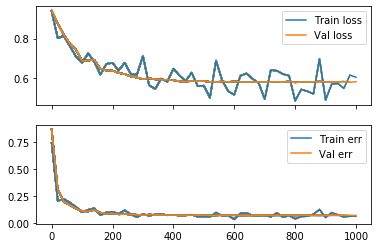

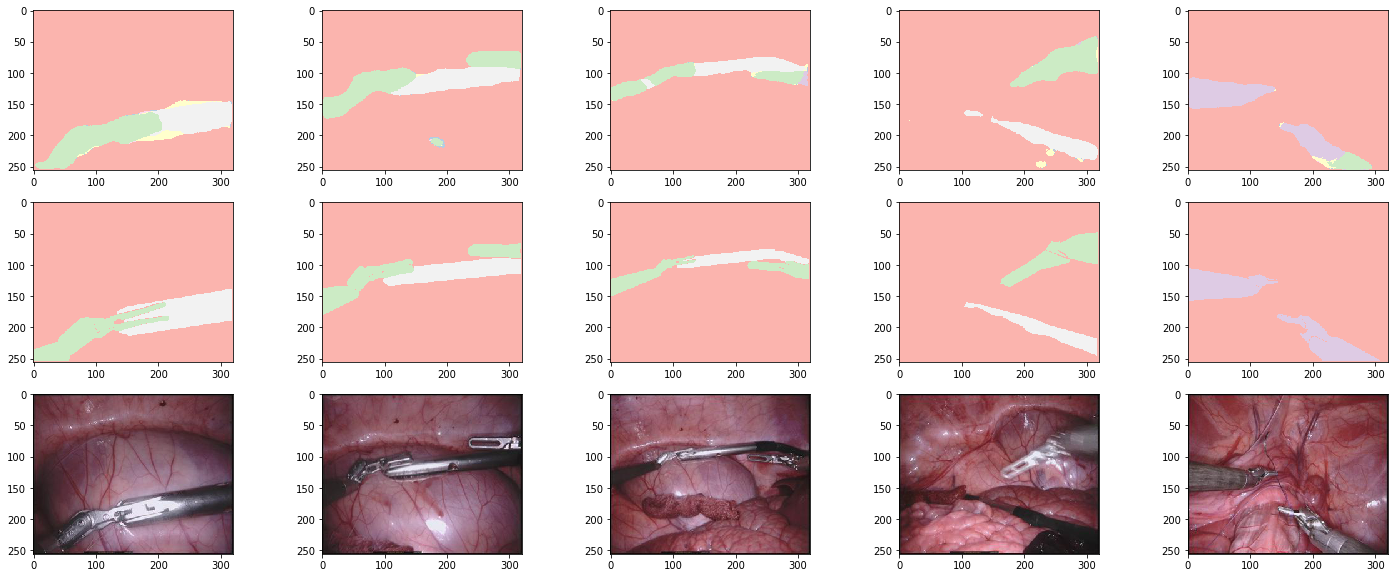

test accuracy: 0.9348
Start Training...Seed 1738 ...lr:  0.001
Step     0: Obtained a best validation error of 0.595.
Step    20: Obtained a best validation error of 0.355.
Step   220: Obtained a best validation error of 0.353.
Step   280: Obtained a best validation error of 0.352.
Step   300: Obtained a best validation error of 0.334.
Step   360: Obtained a best validation error of 0.324.


KeyboardInterrupt: ignored

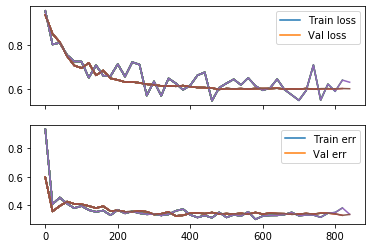

In [0]:
# variables
num_classes = 8
train_batch_size = 10
validation_batch_size= 50
seed_index = 1737
num_seed =  10
num_example = 5
# max epochs
num_epoch = 1001
learning_rate_list = [.001]
for i in range(num_seed):
  for k in range(len(learning_rate_list)):
    experiment_main_1c(iteration=i,num_example=num_example,seed_index=seed_index,num_epoch=num_epoch,learning_rate = learning_rate_list[k])

### DLHW6 Problem 1 Part d

---------------------------------------
---------------------------------------
---------------------------------------
---------------------------------------
---------------------------------------
---------------------------------------

In [0]:
# unet cell part d
# U-Net 
# changed initial layer input channels to 1 for greyscale
# changed last layer output channel to 3 for RGB colors
class unet_1d(nn.Module):
  def __init__(self, useBN=False):
    super(unet_1d, self).__init__()
    # Downgrade stages
    self.conv1 = add_conv_stage(1, 32, useBN=useBN)
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    # final layer
    self.conv5 = nn.Conv2d(32,3,kernel_size=1,stride=1,padding=0,bias=True)
    # weight initialization
    # You can have your own weight intialization. This is just an example.
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        m.reset_parameters()
        #torch.nn.init.xavier_normal_(m.weight.data) # bad
        #torch.nn.init.xavier_uniform_(m.weight.data) # bad
        torch.nn.init.kaiming_normal_(m.weight.data) # not as bad, can be spotty
        #torch.nn.init.normal_(m.weight.data) # bad
        #torch.nn.init.kaiming_uniform_(m.weight.data) # bad, very spotty
        if m.bias is not None:
          m.bias.data.zero_()

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out  = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out  = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out  = self.conv1m(conv2m_out_)
    # final 1 x 1 convolutional layer with softmax activation
    convfinal_out = functional.softmax(self.conv5(conv1m_out), dim=1)
    # convfinal_out = functional.leaky_relu(self.conv5(conv1m_out), negative_slope=0.1)
    #convfinal_out = torch.sigmoid(self.conv5(conv1m_out))

    return convfinal_out

In [0]:
def experiment_main_1d(iteration,num_example,seed_index,num_epoch,learning_rate):
  # experiment cell
  # problem 1a
  # hyperparameters
  learning_rate = learning_rate
  num_epoch =  num_epoch
  torch.manual_seed(seed_index+iteration)
  num_steps_per_val = 20

  model = unet_1d(useBN=True)

  model.cuda()
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

  info = []

  # ImageDataset Objects
  image_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/colorization/train_cor', mode='color',transform=True)
  val_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/colorization/validation_cor',mode = 'color',transform=True)

  # dataloader objects and enumerate for train and test datasets
  dataloader_train = DataLoader(image_dataset, batch_size = train_batch_size, shuffle=True)
  # dataloader_train_iterator = enumerate(dataloader_train)

  dataloader_validation = DataLoader(val_dataset, batch_size = validation_batch_size, shuffle=True)
  # dataloader_validation_iterator = enumerate(dataloader_validation)

  best_val_err = 1.0
  fig, ax = plt.subplots(2, 1, sharex=True)

  print("Start Training...Seed", seed_index+ iteration,'...lr: ',learning_rate)
  convergence_counter = 0
  for epoch in range(num_epoch):
    ########################### Training #####################################
    model.train()

    dataloader_train_iterator = enumerate(dataloader_train)
    i_batch,item_batch = next(dataloader_train_iterator)
    input_batch = item_batch['image'].cuda()
    label_batch = item_batch['mask'].cuda()

    output_batch = model(input_batch)

    # unit tested label_batch is the one hot encoded array mask/label
    # plot_onehot(label_batch[0].cpu().detach().numpy())

    # Compute loss (and error rate).
    loss_fn = nn.MSELoss()
    loss = loss_fn(output_batch, label_batch)  
    train_loss = loss.item()

    # resets gradients and does backpropagation to find gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # converts tensors to numpy arrays for computation to reduce CUDA memory usage
    output_batch = output_batch.cpu().detach().numpy()
    label_batch = label_batch.float().cpu().detach().numpy()

    # output_batch is shape (batch_size, #classes, image size tuple) 
    # every value is the probability of the class for that example for a certain pixel
    output_batch_indices = np.argmax(output_batch,axis = 1)
    # output_batch_indices is of shape (batch_size,image size tuple)
    # label_batch is a one hot encoded tensor of shape (batch_size,#classes, image size tuple)
    # a correct match would then be output_batch_indices == max(label_batch in the class dimen)

    train_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()
    

    ########################### Validation #####################################
    if epoch % num_steps_per_val == 0:
      with torch.no_grad():
        # print("\nEPOCH " +str(epoch+1)+" of "+str(num_epoch)+"\n")
        model.eval()

        dataloader_validation_iterator = enumerate(dataloader_validation)
        i_batch,item_batch = next(dataloader_validation_iterator)
        input_batch = item_batch['image'].cuda()
        label_batch = item_batch['mask'].cuda()
        output_batch = model(input_batch)
        
        # computes loss using dice loss
        loss_fn = nn.MSELoss()
        loss = loss_fn(output_batch, label_batch)  
        val_loss = loss.item()

        # converts tensors to numpy arrays for computation to reduce CUDA memory usage
        output_batch = output_batch.cpu().detach().numpy()
        output_batch_indices = np.argmax(output_batch,axis = 1)
        label_batch = label_batch.float().cpu().detach().numpy()
        
        # computes error rate by comparing predicted class and true class for all batch examples
        val_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()

        if val_err < best_val_err:
              best_val_err = val_err
              print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(epoch, best_val_err))
              convergence_counter = 0
        else:
              convergence_counter +=1
              # if convergence_counter > number of validation checks
              if convergence_counter > 50:
                print('stopped training on epoch: ', epoch)
                break

        # plotting
        info.append([epoch, train_loss, val_loss, train_err, val_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'Val loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'Val err'])
  plt.show()
  torch.save(model.state_dict(), 'unet_color.pth')

Start Training...Seed 3800 ...lr:  0.001
Step     0: Obtained a best validation error of 0.416.
Step    20: Obtained a best validation error of 0.261.
Step    40: Obtained a best validation error of 0.040.


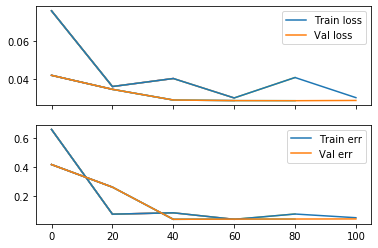

In [0]:
# variables
num_classes = 8
train_batch_size = 10
validation_batch_size= 50
seed_index = 3800
num_seed =  1
num_example = 5
# max epochs
num_epoch = 101
learning_rate_list = [.001]
for i in range(num_seed):
  for k in range(len(learning_rate_list)):
    experiment_main_1d(iteration=i,num_example=num_example,seed_index=seed_index,num_epoch=num_epoch,learning_rate = learning_rate_list[k])

### DLHW6 Problem 1 Part e

--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------
--------------------------------------------

In [0]:
def experiment_main_1e(iteration,num_example,seed_index,num_epoch,learning_rate):
  # experiment cell
  # problem 1a
  # hyperparameters
  learning_rate = learning_rate
  num_epoch =  num_epoch

  torch.manual_seed(seed_index+iteration)
  num_steps_per_val = 20

  model = unet_1d(useBN=True)

  state_dict = torch.load('unet_color.pth')

  # freezes all layers 
  for m in model.modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
      m.requires_grad = False
  # makes new first and last layer to fit segmentation task
  model.conv1[0] = nn.Conv2d(3,32,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  model.conv5 = nn.Conv2d(32,8,kernel_size=(1, 1), stride=(1, 1))


  model.cuda()
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

  info = []

  # ImageDataset Objects
  image_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/train', mode='dice',transform=True)
  val_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/validation',mode = 'dice',transform=True)

  # dataloader objects and enumerate for train and test datasets
  dataloader_train = DataLoader(image_dataset, batch_size = train_batch_size, shuffle=True)
  # dataloader_train_iterator = enumerate(dataloader_train)

  dataloader_validation = DataLoader(val_dataset, batch_size = validation_batch_size, shuffle=True)
  # dataloader_validation_iterator = enumerate(dataloader_validation)

  best_val_err = 1.0
  fig, ax = plt.subplots(2, 1, sharex=True)

  print("Start Training...Seed", seed_index+ iteration,'...lr: ',learning_rate)
  convergence_counter = 0
  for epoch in range(num_epoch):
    ########################### Training #####################################
    model.train()

    dataloader_train_iterator = enumerate(dataloader_train)
    i_batch,item_batch = next(dataloader_train_iterator)
    input_batch = item_batch['image'].cuda()
    label_batch = item_batch['mask'].cuda()

    output_batch = model(input_batch)

    # unit tested label_batch is the one hot encoded array mask/label
    # plot_onehot(label_batch[0].cpu().detach().numpy())

    # Compute loss (and error rate).
    loss_fn = DICELoss()
    loss = loss_fn(output_batch, label_batch)  
    train_loss = loss.item()

    # resets gradients and does backpropagation to find gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # converts tensors to numpy arrays for computation to reduce CUDA memory usage
    output_batch = output_batch.cpu().detach().numpy()
    label_batch = label_batch.float().cpu().detach().numpy()

    # output_batch is shape (batch_size, #classes, image size tuple) 
    # every value is the probability of the class for that example for a certain pixel
    output_batch_indices = np.argmax(output_batch,axis = 1)
    # output_batch_indices is of shape (batch_size,image size tuple)
    # label_batch is a one hot encoded tensor of shape (batch_size,#classes, image size tuple)
    # a correct match would then be output_batch_indices == max(label_batch in the class dimen)

    train_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()
    

    ########################### Validation #####################################
    if epoch % num_steps_per_val == 0:
      with torch.no_grad():
        # print("\nEPOCH " +str(epoch+1)+" of "+str(num_epoch)+"\n")
        model.eval()

        dataloader_validation_iterator = enumerate(dataloader_validation)
        i_batch,item_batch = next(dataloader_validation_iterator)
        input_batch = item_batch['image'].cuda()
        label_batch = item_batch['mask'].cuda()
        output_batch = model(input_batch)
        
        # computes loss using dice loss
        loss_fn = DICELoss()
        loss = loss_fn(output_batch, label_batch)  
        val_loss = loss.item()

        # converts tensors to numpy arrays for computation to reduce CUDA memory usage
        output_batch = output_batch.cpu().detach().numpy()
        output_batch_indices = np.argmax(output_batch,axis = 1)
        label_batch = label_batch.float().cpu().detach().numpy()
        
        # computes error rate by comparing predicted class and true class for all batch examples
        val_err = 1.0 - (output_batch_indices == np.argmax(label_batch,axis=1)).mean()

        if val_err < best_val_err:
              best_val_err = val_err
              print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(epoch, best_val_err))
              convergence_counter = 0
        else:
              convergence_counter +=1
              # if convergence_counter > number of validation checks
              if convergence_counter > 50:
                print('stopped training on epoch: ', epoch)
                break

        # plotting
        info.append([epoch, train_loss, val_loss, train_err, val_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'Val loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'Val err'])
        # ax[2].plot(x[1:],y21[1:],x[1:],y22[1:])
        # ax[2].legend(['Train err skip first iteration','Val err skip first iteration'])
  plt.show()

  # test performance

  with torch.no_grad():
    test_dataset = ImageDataset(input_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test', mode='dice')
    dataloader_test = DataLoader(test_dataset, batch_size = 49, shuffle=False) # 49 because of 49 test images

    dataloader_test_iterator = enumerate(dataloader_test)
    _,batch_data = next(dataloader_test_iterator)

    input_batch = batch_data['image'].cuda()
    label_batch = batch_data['mask'].cuda()

    output_batch = model(input_batch)

    output_batch = output_batch.cpu().detach().numpy()
    output_batch_indices = np.argmax(output_batch,axis = 1)

    fig = plt.figure()
    fig.set_figheight(5*2)
    fig.set_figwidth(5*num_example)
    offset = 7
    for i in range(num_example):
      plt.subplot(3,num_example,i+1)
      plot_onehot(output_batch[i,:,:,:])
      plt.subplot(3,num_example,i+num_example+1)
      plot_onehot(label_batch[i,:,:,:].cpu().detach().numpy())
      # code to check if raw images are right
      plt.subplot(3,num_example,i+2*num_example+1)
      plt.imshow(input_batch[i].cpu().detach().numpy().transpose((1,2,0)))
    plt.show()


    # computes error rate by comparing predicted class and true class for all batch examples
    test_err = 1.0 - (output_batch_indices == np.argmax(label_batch.float().cpu().detach().numpy(),axis=1)).mean()

    print("test accuracy: %0.4f" %(1-test_err))

Start Training...Seed 1741 ...lr:  0.001
Step     0: Obtained a best validation error of 0.989.
Step    20: Obtained a best validation error of 0.188.
Step    80: Obtained a best validation error of 0.140.
Step   120: Obtained a best validation error of 0.106.
Step   140: Obtained a best validation error of 0.095.
Step   160: Obtained a best validation error of 0.094.
Step   200: Obtained a best validation error of 0.091.
Step   220: Obtained a best validation error of 0.088.
Step   260: Obtained a best validation error of 0.087.
Step   300: Obtained a best validation error of 0.085.
Step   340: Obtained a best validation error of 0.085.
Step   360: Obtained a best validation error of 0.084.
Step   440: Obtained a best validation error of 0.083.
Step   480: Obtained a best validation error of 0.082.
Step   500: Obtained a best validation error of 0.081.
Step   580: Obtained a best validation error of 0.080.
Step   640: Obtained a best validation error of 0.080.


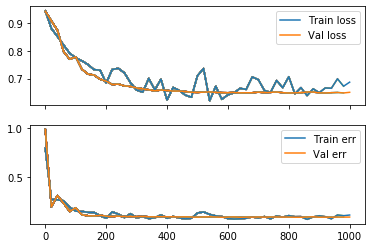

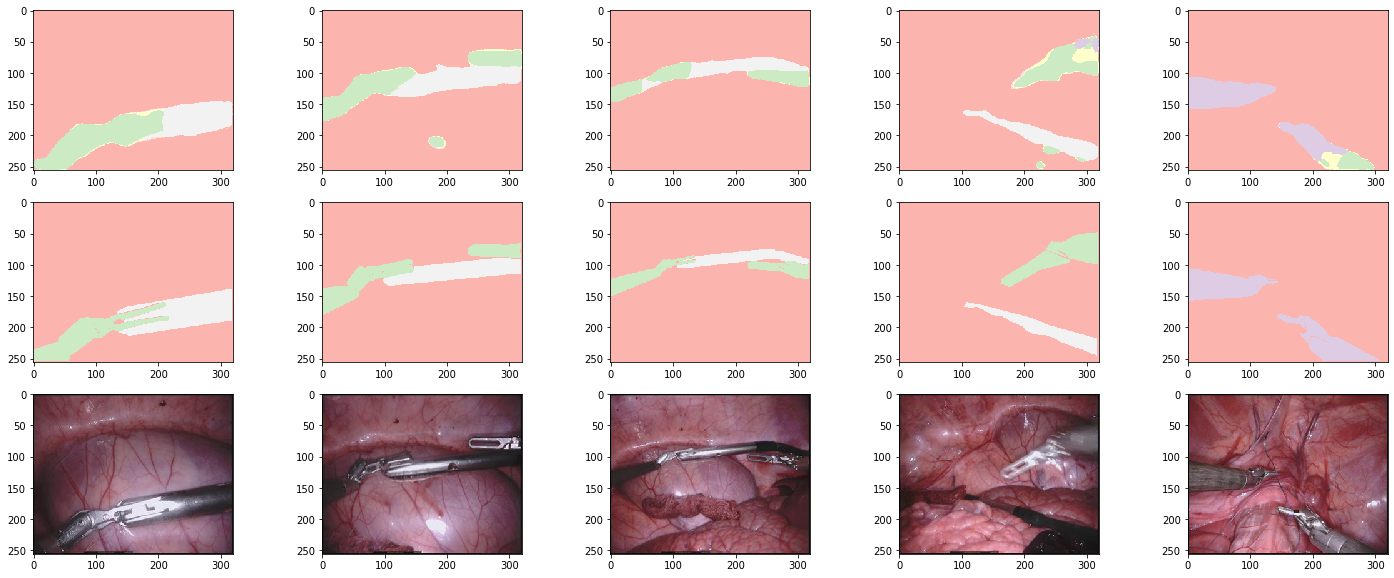

test accuracy: 0.9242


In [0]:
# variables
num_classes = 8
train_batch_size = 10
validation_batch_size= 50
seed_index = 1741
num_seed =  1
num_example = 5
# max epochs
num_epoch = 1001
learning_rate_list = [.001]
for i in range(num_seed):
  for k in range(len(learning_rate_list)):
    experiment_main_1e(iteration=i,num_example=num_example,seed_index=seed_index,num_epoch=num_epoch,learning_rate = learning_rate_list[k])

In [0]:
# Question 2 Part a
import torchvision
from torchvision.datasets import FashionMNIST
# loads Fashion-MNIST dataset
data_train_MNIST = FashionMNIST(root = 'HOME/data/Fashion-MNIST/processed/',train=True,download=True)
train_data = data_train_MNIST.train_data.numpy()
train_label = data_train_MNIST.train_labels.numpy()


data_test_MNIST = FashionMNIST(root = 'HOME/data/Fashion-MNIST/processed/',train=False,download=True)
test_data = data_test_MNIST.test_data.numpy()
test_label = data_test_MNIST.test_labels.numpy()

# data parameters
num_train_examples = train_data.shape[0] # 60000 for MNIST fashion
num_test_examples = test_data.shape[0] # 10000 for MNIST fashion
WIDTH, HEIGHT = train_data.shape[1],train_data.shape[2] # 28, 28 for MNIST fashion
num_classes = np.unique(train_label).shape[0] # 10 for MNIST fashion

0it [00:00, ?it/s]

26427392it [00:02, 10939397.38it/s]                             


Extracting HOME/data/Fashion-MNIST/processed/FashionMNIST/raw/train-images-idx3-ubyte.gz to HOME/data/Fashion-MNIST/processed/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 71511.54it/s]                            
0it [00:00, ?it/s]

Extracting HOME/data/Fashion-MNIST/processed/FashionMNIST/raw/train-labels-idx1-ubyte.gz to HOME/data/Fashion-MNIST/processed/FashionMNIST/raw


4423680it [00:01, 3091354.25it/s]                            
0it [00:00, ?it/s]

Extracting HOME/data/Fashion-MNIST/processed/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to HOME/data/Fashion-MNIST/processed/FashionMNIST/raw


8192it [00:00, 23017.79it/s]            


Extracting HOME/data/Fashion-MNIST/processed/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to HOME/data/Fashion-MNIST/processed/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
# Dataset Creation Class
TRAIN_MEAN = [0.485,0.456,0.406]
TRAIN_STD = [0.229,0.224,0.225]
train_transform = transforms.Compose([
    transforms.Normalize(TRAIN_MEAN, TRAIN_STD)
])

class MNISTDataset(Dataset):
  """
  for mode 'MNIST':
    input is the data numpy array with size (num_examples,image height, image width) 
    and label numpy array with size (num_examples).

    output is data tensor with size (num_examples, 3 channels, image height, image width)
    and label tensors with size (num_examples)
  """
  def __init__(self, data_all, label_all, mode = 'MNIST', transform=None):
    self.data_all = data_all
    self.label_all = label_all

    self.mode = mode 
    self.transform = transform

  def __len__ (self):
    return self.data_all.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    if self.mode == 'MNIST':
      # only take data example at index idx
      data = self.data_all[idx,:,:] / 255
      # view() adds extra channel to input data
      # repeat() repeats data for 3 channels to fit VGG model 
      data = np.repeat(data.reshape(1,28,28),3,axis=0)
      data = torch.from_numpy(data).float()

      label = torch.from_numpy(np.array(self.label_all[idx])).float()

      if self.transform:
        data = self.transform(data)


    item = {'image': data, 'mask': label}
    return item
    

In [0]:
def experiment_main(num_epoch,learning_rate):
  # experiment cell
  # problem 1a
  # hyperparameters
  learning_rate = learning_rate
  num_epoch =  num_epoch

  num_steps_per_test = 20

  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  info = []

  # ImageDataset Objects
  train_dataset = MNISTDataset(train_data,train_label,mode='MNIST',transform=train_transform)
  test_dataset = MNISTDataset(test_data,test_label,mode='MNIST',transform=train_transform)

  # dataloader objects for train and test datasets
  dataloader_train = DataLoader(train_dataset, batch_size = train_batch_size, shuffle=True)
  dataloader_test = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=True)


  best_test_err = 1.0
  fig, ax = plt.subplots(3, 1, sharex=True)

  print("Start Training,...lr: ",learning_rate)
  convergence_counter = 0
  for epoch in range(num_epoch):
    ########################### Training #####################################

    dataloader_train_iterator = enumerate(dataloader_train)
    i_batch,item_batch = next(dataloader_train_iterator)
    input_batch = item_batch['image'].cuda()
    label_batch = item_batch['mask'].cuda()
    output_batch = model(input_batch)

    # print('output_batch size',output_batch.size())
    # print(output_batch[0,:])
    # print('input_batch size',input_batch.size(),'label batch size',label_batch.size())
    # print(torch.unique(input_batch[0,:,:]))
    # print(label_batch[:])
    # print('mean', torch.mean(input_batch[0],dim=(1,2)))
    # print('std',torch.std(input_batch[0],dim=(1,2)))

    # Compute loss (and error rate).
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output_batch, label_batch.long())  

    train_loss = loss.item()

    # resets gradients and does backpropagation to find gradients
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    #scheduler.step()

    # converts tensors to numpy arrays for computation to reduce CUDA memory usage
    output_batch = output_batch.cpu().detach().numpy()
    label_batch = label_batch.cpu().detach().numpy()

    train_err = 1.0 - (np.argmax(output_batch,axis=1) == label_batch).mean()
  

    ########################### test #####################################
    if epoch % num_steps_per_test == 0:
      with torch.no_grad():
        # print("\nEPOCH " +str(epoch+1)+" of "+str(num_epoch)+"\n")
        model.eval()

        dataloader_test_iterator = enumerate(dataloader_test)
        i_batch,item_batch = next(dataloader_test_iterator)
        input_batch = item_batch['image'].cuda()
        label_batch = item_batch['mask'].cuda()

        output_batch = model(input_batch)
        # computes loss using dice loss
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(output_batch, label_batch.long())  
        test_loss = loss.item()

        # converts tensors to numpy arrays for computation to reduce CUDA memory usage
        output_batch = output_batch.cpu().detach().numpy()
        label_batch = label_batch.cpu().detach().numpy()
        
        # computes error rate by comparing predicted class and true class for all batch examples
        test_err = 1.0 - (np.argmax(output_batch,axis=1) == label_batch).mean()

        if test_err < best_test_err:
              best_test_err = test_err
              print('Step {:5d}: Obtained a best test error of {:.3f}.'.format(epoch, best_test_err))
              convergence_counter = 0
        else:
              convergence_counter +=1
              # if convergence_counter > number of test checks
              if convergence_counter > 150:
                print('stopped training on epoch: ', epoch)
                break

        # plotting
        info.append([epoch, train_loss, test_loss, train_err, test_err])
        x, y11, y12, y21, y22 = zip(*info)
        ax[0].plot(x, y11, x, y12)
        ax[0].legend(['Train loss', 'test loss'])
        ax[1].plot(x, y21, x, y22)
        ax[1].legend(['Train err', 'test err'])
        ax[2].plot(x[1:],y21[1:],x[1:],y22[1:])
        ax[2].legend(['Train err skip first iteration','test err skip first iteration'])
  plt.show()
  print('test accuracy :', 1 - best_test_err)
  print(info)

Start Training,...lr:  0.001
Step     0: Obtained a best test error of 0.880.
Step   120: Obtained a best test error of 0.820.
Step   500: Obtained a best test error of 0.780.


KeyboardInterrupt: ignored

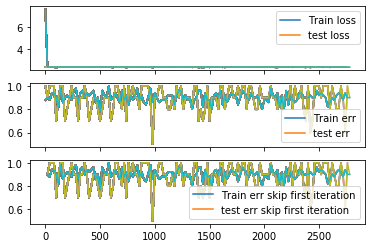

In [0]:
# global variables
torch.manual_seed(11)
train_batch_size = 10
test_batch_size = 50
num_epoch = 5001
learning_rate_list = [.001,.0001]

for k in range(len(learning_rate_list)):
  model = torchvision.models.vgg16(pretrained=False, progress=True)
  # changes model to fit MNIST data
  # specifically deleted last maxpool in model.features and changed last layer output from 1000 to output num_classes 
  model.features = nn.Sequential(*list(model.features.children())[:-1])
  model.classifier[6] = nn.Linear(4096,10)
  model.cuda()

  experiment_main(num_epoch=num_epoch,learning_rate = learning_rate_list[k])

In [0]:
# Question 2 part b

# global variables
train_batch_size = 50
test_batch_size = 50
num_epoch = 5001
learning_rate_list = [.001,.0001]

for k in range(len(learning_rate_list)):
  model = torchvision.models.vgg16(pretrained=False, progress=True)

  state_dict = torch.load("vgg16-397923af.pth")
  model.load_state_dict(state_dict)
  model.features = nn.Sequential(*list(model.features.children())[:-1])
  model.classifier[6] = nn.Linear(4096,10)

  # test code for freezing
  # freezes all Conv2d layers
  for child in model.features:
    if isinstance(child, nn.Conv2d):
      for param in child.parameters():
        param.requires_grad = False
  # freezes all linear layers except for last
  count = 0
  for child in model.classifier:
    if isinstance(child, nn.Linear):
      count += 1
      if count < 2:
        for param in child.parameters():
          param.requires_grad = False 
      if count > 2:
        for param in child.parameters():
          param.requires_grad = True
  model.cuda()

  experiment_main(num_epoch=num_epoch,learning_rate = learning_rate_list[k])

FileNotFoundError: ignored

In [0]:
# Question 2 part c

# unfreezing all Linear Layers

# global variables
train_batch_size = 50
test_batch_size = 50
num_epoch = 5001
learning_rate_list = [.001,.0001]

for k in range(len(learning_rate_list)):
  model = torchvision.models.vgg16(pretrained=False, progress=True)

  state_dict = torch.load("vgg16-397923af.pth")
  model.load_state_dict(state_dict)
  model.features = nn.Sequential(*list(model.features.children())[:-1])
  model.classifier[6] = nn.Linear(4096,10)

  # test code for freezing
  # freezes all Conv2d layers
  for child in model.features:
    if isinstance(child, nn.Conv2d):
      for param in child.parameters():
        param.requires_grad = False
  # freezes all linear layers except for last
  count = 0
  for child in model.classifier:
    if isinstance(child, nn.Linear):
        for param in child.parameters():
          param.requires_grad = True
  model.cuda()  

  experiment_main(num_epoch=num_epoch,learning_rate = learning_rate_list[k])

In [0]:
# # input, output, label batch size debug commands
# print('output_batch size',output_batch.size())
# print(output_batch[0,:])
# print('input_batch size',input_batch.size(),'label batch size',label_batch.size())
# print(torch.unique(input_batch[0,:,:]))
# print(label_batch[:])


# testing normalize function from transforms
# normalize = transforms.Normalize(TRAIN_MEAN, TRAIN_STD)

# test = torch.zeros(3,4,4)
# test[0,:,:] = torch.FloatTensor([[.2,.3,.4,.5],[.3,.4,.5,.6],[.2,.3,.4,.5],[.2,.3,.4,.5]])
# test[1,:,:] = torch.FloatTensor([[.2,.3,.4,.5],[.2,.3,.4,.5],[.2,.3,.4,.5],[.2,.3,.4,.5]])
# test[2,:,:] = torch.FloatTensor([[.2,.3,.4,.5],[.2,.3,.4,.5],[.2,.3,.4,.8],[.2,.3,.4,.5]])

# normalize(test)

# print(torch.mean(test,dim=(1,2)))
# print(torch.std(test,dim=(1,2)))

# test code for freezing
# # freezes all Conv2d layers
# for child in model.features:
#   if isinstance(child, nn.Conv2d):
#     for param in child.parameters():
#       param.requires_grad = False
# # freezes all linear layers except for last
# count = 0
# for child in model.classifier:
#    if isinstance(child, nn.Linear):
#      if count < 2:
#        for param in child.parameters():
#          param.requires_grad = False 

In [0]:
# interesting seeds
# 1604, 1603, 1599, 3800

# # diceloss cell
# # attempted weighted diceloss probably needs debugging (currently favors only 2 to 3 classes)
# class DICELoss_1c(nn.Module):
#   def __init__(self):
#     super(DICELoss_1c, self).__init__()
#     # smoothing
#     self.smooth = 1
  
#   def forward(self, output_array, target_array, epoch):
#     # extracts batch_size from first dimension of target array
#     batch_size = target_array.size()[0]

#     # flattens output array and target array so that there is one
#     # flattened vector for each example in the batch and each class
#     output_flat = output_array.view(batch_size,num_classes,-1)
#     target_flat = target_array.view(batch_size,num_classes,-1)

#     # calculates intersection between output and target. It will be higher if 
#     # probability in output vector is larger for the nonzero value in target one
#     # hot encoded vector
#     intersection = torch.sum(output_flat * target_flat, dim=2)

    
#     # loss is caculated as 1 - dice score
#     # per class and example, the dice score is 2 * intersection = smoothing constant / (sum of individual
#     # sets + smoothing constant)
#     # smoothing is implemented for cases where certain classes do not show up in the image
#     # the dice_score below is an array of size (batch_size, num_classes)
#     numerator = 2. * intersection + self.smooth
#     denominator = torch.sum(output_flat,dim=2) + torch.sum(target_flat,dim=2) + self.smooth
#     dice_score = numerator / denominator

#     # if epoch < 100:
#     #     dice_score[:,0] = 0

#     ### old weight code
#     weight = torch.zeros(batch_size,num_classes).cuda()
#     for i in range(batch_size):
#       for j in range(num_classes):
#         weight[i,j] = torch.sum(target_flat[i,j,:])

#     # image height * width
#     weight /= 81920
#     dice_score = dice_score * weight
#     ###


#     dice_score = torch.mean(dice_score,dim=0)

#     dice_score = torch.mean(dice_score,dim=0)

#     # print(torch.mean(dice_score[1:]))
#     # # we then take the mean over all classes
#     # if (torch.mean(dice_score[1:])) < 0.995:
#     #   dice_score = torch.mean(dice_score[1:])
#     # else:
#     #   print('executes')
#     #   dice_score = torch.mean(dice_score)

#     loss = 1 - dice_score
#     return loss

In [0]:
 # debugging statements

## checking if outputs and label batches are correct shape and values
# print('output size: ', output_batch.size())
# print('output values in first example, all channels across 100-110 row pixels in the 101st column', output_batch[0,:,101, 100:110])
# print('label size: ', label_batch.size())
# print('label values in first example across 100-110 row pixels in the 101st column', label_batch[0,101, 100:110])

## output_batch_max returns (tensor(values), tensor(indices))
## using numpy argmax instead for now
# output_batch_max = torch.max(output_batch, 1)
# output_batch_values = output_batch_max[0].view(-1,1)
# output_batch_indices = output_batch_max[1]

## numpy exercise for testing argmax
# from numpy import random
# test = np.zeros((8,16,16))
# for i in range(test.shape[1]):
#   for j in range(test.shape[2]):
#     random_int = random.randint(0,8)
#     test[random_int,i,j] = 1

## code to visualize one hot encoded numpy array (for debugging)
# def plot_onehot(x):
#   """
#   takes array x with dimensions (# classes, image height, image width)
#   and plots it with plt.imshow()
#   """
#   indices = np.argmax(x,0)
#   plt.imshow(indices)


# test = np.zeros((3,2,2))
# test[0,0,1] = 1
# test[1,0,0] = 1
# test[1,1,0] = 1
# test[2,1,1] = 1

# plot_onehot(test)

# checking color map Pastel1 colors for 8 classes 
# test = np.zeros((8,8))
# test_values = [0,np.round(32/255,3),np.round(64/255,3),np.round(96/255,3),np.round(128/255,3),np.round(160/255,3),np.round(192/255,3),np.round(224/255,3)]
# for i in range(8):
#   test[i,:] = test_values[i]


# plt.imshow(test,cmap='Pastel1')

# # test to see argmax interaction with 3d arrays
# test = np.zeros((3,2,2))
# test[0,:,1] = True
# test[1,0,0] = True
# test[2,1,0] = True

# indices = np.argmax(test,axis=0)
# print(indices)

# # more tests to check if one hot encoded array is right for masks
# test = label_batch[0,:,:].cpu().detach().numpy()
# indices = np.argmax(test,0)
# print(np.unique(indices))
# test2 = test = label_batch[1,:,:].cpu().detach().numpy()
# indices = np.argmax(test2,0)
# print(np.unique(indices))

# image1 = Image.open('DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test/11/11_mask.png')
# plt.subplot(1,2,1)
# plt.imshow(image1,cmap='Pastel1')
# plt.subplot(1,2,2)
# image2 = Image.open('DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test/47/47_mask.png')
# plt.imshow(image2,cmap='Pastel1')

#  # debugging by examining output scores per class
#   fig = plt.figure()
#   fig.set_figheight(6)
#   fig.set_figwidth(14)
#   for i in range(num_classes):
#     plt.subplot(1,9,i+1)
#     plt.imshow(output_batch[0,i,:,:], vmin=0,vmax=0,)
#   print(np.argmax(output_batch[0,:,:,:],axis=0).shape)
#   plt.subplot(1,9,9)
#   plt.imshow(np.argmax(output_batch[0,:,:,:],axis=0))

# # checking to see if raw masks match one hot encoded array masks, this part is for raw masks
# image1 = Image.open('DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test/11/11_mask.png')
# plt.subplot(1,2,1)
# plt.imshow(image1,cmap='Pastel1',vmin=0,vmax=255)
# plt.subplot(1,2,2)
# image2 = Image.open('DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test/47/47_mask.png')
# plt.imshow(image2,cmap='Pastel1',vmin=0,vmax=255)

# # understanding dim arguments

# test = np.array([[[1,1,1],[2,2,2]],[[3,3,3],[4,4,4]],[[5,5,5],[6,6,6]],[[7,7,7],[8,8,8]]])
# print(test)
# print(test.shape)

# print(np.sum(test))
# print(np.sum(test,axis=(0,2)))
# print(np.sum(test,axis=(0,2)).shape)

# print(test[0,0,0])

# # unit test to check if dice loss gives loss 0 with all ones and loss 1 with all 0s in one hot encoded tensor

# # comment one or the other out
# unittest_label = torch.zeros(10,8,256,320)
# num_classes = 8
# #unittest_label = torch.ones(10,8,256,320)

# # dummy output scores
# unittest_output = torch.ones(10,8,256,320)

# unittest_loss = DICELoss()
# loss = unittest_loss(unittest_output,unittest_label)
# print(loss.item())

# # old weight code
#     weight = torch.zeros(batch_size,num_classes).cuda()
#     for i in range(batch_size):
#       for j in range(num_classes):
#         weight[i,j] = torch.sum(target_flat[i,j,:])

#     # # threshold to ignore background class
#     # if torch.mean(dice_score[1:]) < 0.95 and epoch < 100:
#     #   weight[:,0] = 0

#     # image height * width
#     weight /= 81920
#     dice_score = dice_score * weight
